<a href="https://colab.research.google.com/github/khoji-code/Data-Science-AI-for-Business-Portfolio/blob/main/Product_Ecosystems_with_Network_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product_Ecosystems_with_Network_Analysis

### Project Overview
* Analyzes a real-world **Online Retail** dataset to understand the relationships between products that are frequently purchased together.
* Uses an advanced analytical technique called **Network Analysis** to model the product catalog as a graph, where products are nodes and co-purchases are connections.
* Employs **centrality metrics** to quantitatively identify the most important "hub" products that are central to the sales network.
* Applies the **Louvain community detection** algorithm to automatically discover natural clusters of related products, revealing hidden "product ecosystems."
* The final output is a rich, visual representation of the product network and a data-driven map of these ecosystems.

***

### Purpose of the Project
* To move beyond simple sales analysis and uncover the **hidden, non-obvious relationships** that exist within a product catalog.
* To provide a **powerful and strategic view** of the business's product landscape, identifying not just what sells, but what sells *together*.
* To create **immediately actionable intelligence** that can drive high-value business strategies, including:
    * **Data-Driven Product Bundling:** Creating effective promotions by bundling items from the same ecosystem.
    * **Optimized Store Layouts:** Placing related products near each other to increase cross-selling.
    * **Improved Recommendation Engines:** Suggesting other products from the same community to online shoppers.
* To transform transactional data into a visual and intuitive tool that helps strategists understand distinct customer need states and market opportunities.

### Dataset:
http://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx

## INSTALLATION

In [1]:
!pip install pandas scikit-learn matplotlib seaborn networkx community -q
print("Libraries installed")

Libraries installed


## IMPORT LIBRARIES

In [10]:
import numpy as np
import pandas as pd
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter

# Set plotting style
sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8-whitegrid')

print("All libraries imported")


All libraries imported


## DATA LOADING AND PREPROCESSING

In [3]:
# Load the dataset from the reliable UCI repository URL
df_ = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx', sheet_name='Year 2010-2011')
df = df_.copy()

# Data Cleaning
df.dropna(axis=0, subset=['Invoice', 'Description'], inplace=True)
df = df[~df['Invoice'].str.contains('C', na=False)]
df['Description'] = df['Description'].str.strip()
# For this analysis - focus on a single country to get clearer patterns
df = df[df['Country'] == 'United Kingdom']

print("Data loading and cleaning complete")
print(f"Dataset contains {df.shape[0]} valid transactions from the UK.")

Data loading and cleaning complete
Dataset contains 486168 valid transactions from the UK.


## GENERATING PRODUCT CO-OCCURRENCE DATA

In [4]:
# transform the transaction log into a list of product pairs that were purchased together

# Group products by invoice to get the "baskets"
baskets = df.groupby('Invoice')['Description'].apply(list)

# Pairs of products bought together
pair_counts = Counter()

# Find co-purchased pairs
for basket in baskets:
    # unique pairs of items in the basket
    for pair in combinations(sorted(list(set(basket))), 2):
        pair_counts[pair] += 1

# DataFrame from the pair counts
pair_df = pd.DataFrame(pair_counts.items(), columns=['pair', 'count'])
pair_df[['product1', 'product2']] = pd.DataFrame(pair_df['pair'].tolist(), index=pair_df.index)
pair_df.drop('pair', axis=1, inplace=True)

# For a clearer graph - filter for pairs that were purchased together at least 20 times
pair_df = pair_df[pair_df['count'] >= 20]

print(f"Co-occurrence generation complete. Found {len(pair_df)} significant product pairs")
print("Sample of co-purchased product pairs:")
print(pair_df.head())

Co-occurrence generation complete. Found 328154 significant product pairs
Sample of co-purchased product pairs:
   count                        product1                             product2
0     23  CREAM CUPID HEARTS COAT HANGER    GLASS STAR FROSTED T-LIGHT HOLDER
1     30  CREAM CUPID HEARTS COAT HANGER  KNITTED UNION FLAG HOT WATER BOTTLE
2     21  CREAM CUPID HEARTS COAT HANGER       RED WOOLLY HOTTIE WHITE HEART.
3     30  CREAM CUPID HEARTS COAT HANGER         SET 7 BABUSHKA NESTING BOXES
4    111  CREAM CUPID HEARTS COAT HANGER   WHITE HANGING HEART T-LIGHT HOLDER


## GRAPH CONSTRUCTION AND CENTRALITY ANALYSIS

In [5]:
# Build the network graph and calculate key metrics

# Create a graph from our pairs DataFrame
G = nx.from_pandas_edgelist(pair_df, 'product1', 'product2', edge_attr='count')

print(f"Graph created with {G.number_of_nodes()} nodes (products) and {G.number_of_edges()} edges (co-purchases).")

# Degree Centrality (Popularity)
degree_centrality = nx.degree_centrality(G)
degree_df = pd.DataFrame(degree_centrality.items(), columns=['product', 'degree_centrality']).sort_values('degree_centrality', ascending=False)

print("\nTop 10 Most Connected Products (Hubs)")
print(degree_df.head(10))

# Betweenness Centrality (Bridges)
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame(betweenness_centrality.items(), columns=['product', 'betweenness_centrality']).sort_values('betweenness_centrality', ascending=False)

print("\nTop 10 Most Important Bridge Products ")
print(betweenness_df.head(10))


Graph created with 2285 nodes (products) and 328154 edges (co-purchases).

Top 10 Most Connected Products (Hubs)
                                product  degree_centrality
5    WHITE HANGING HEART T-LIGHT HOLDER           0.813485
106             JUMBO BAG RED RETROSPOT           0.788091
623                      DOTCOM POSTAGE           0.779335
102              JAM MAKING SET PRINTED           0.745622
96       NATURAL SLATE HEART CHALKBOARD           0.725482
438            REGENCY CAKESTAND 3 TIER           0.721103
43      PACK OF 72 RETROSPOT CAKE CASES           0.720228
657     RECIPE BOX PANTRY YELLOW DESIGN           0.705779
39              LUNCH BAG RED RETROSPOT           0.700088
19             JAM MAKING SET WITH JARS           0.697461

Top 10 Most Important Bridge Products 
                                 product  betweenness_centrality
5     WHITE HANGING HEART T-LIGHT HOLDER                0.074389
623                       DOTCOM POSTAGE                0.063755
106

## COMMUNITY DETECTION (LOUVAIN METHOD)

In [8]:
# Find the best partition (communities)
partition = community_louvain.best_partition(G, weight='count', random_state=42)
partition_df = pd.DataFrame(partition.items(), columns=['product', 'community'])

# Merge community data with centrality data for a full picture
analysis_df = pd.merge(degree_df, betweenness_df, on='product')
analysis_df = pd.merge(analysis_df, partition_df, on='product')

print(f"Discovered {analysis_df['community'].nunique()} distinct product communities.")
print("\nSample of Products with their Community and Centrality Scores")
print(analysis_df.head())

# Analyze the content of a few communities
print("\nExample Community Content")
for i in range(3): # Display the top 5 products from the first 3 communities
    print(f"\nCommunity {i}:")
    print(analysis_df[analysis_df['community'] == i].sort_values('degree_centrality', ascending=False).head(5)['product'].tolist())


Discovered 27 distinct product communities.

Sample of Products with their Community and Centrality Scores
                              product  degree_centrality  \
0  WHITE HANGING HEART T-LIGHT HOLDER           0.813485   
1             JUMBO BAG RED RETROSPOT           0.788091   
2                      DOTCOM POSTAGE           0.779335   
3              JAM MAKING SET PRINTED           0.745622   
4      NATURAL SLATE HEART CHALKBOARD           0.725482   

   betweenness_centrality  community  
0                0.074389          0  
1                0.033485          0  
2                0.063755          2  
3                0.018652          0  
4                0.016694          0  

Example Community Content

Community 0:
['WHITE HANGING HEART T-LIGHT HOLDER', 'JUMBO BAG RED RETROSPOT', 'JAM MAKING SET PRINTED', 'NATURAL SLATE HEART CHALKBOARD', 'REGENCY CAKESTAND 3 TIER']

Community 1:
['PRETTY HANGING QUILTED HEARTS', 'NATURAL HANGING QUILTED HEARTS']

Community 2:
['DOTCO

## VISUALIZING THE PRODUCT NETWORK

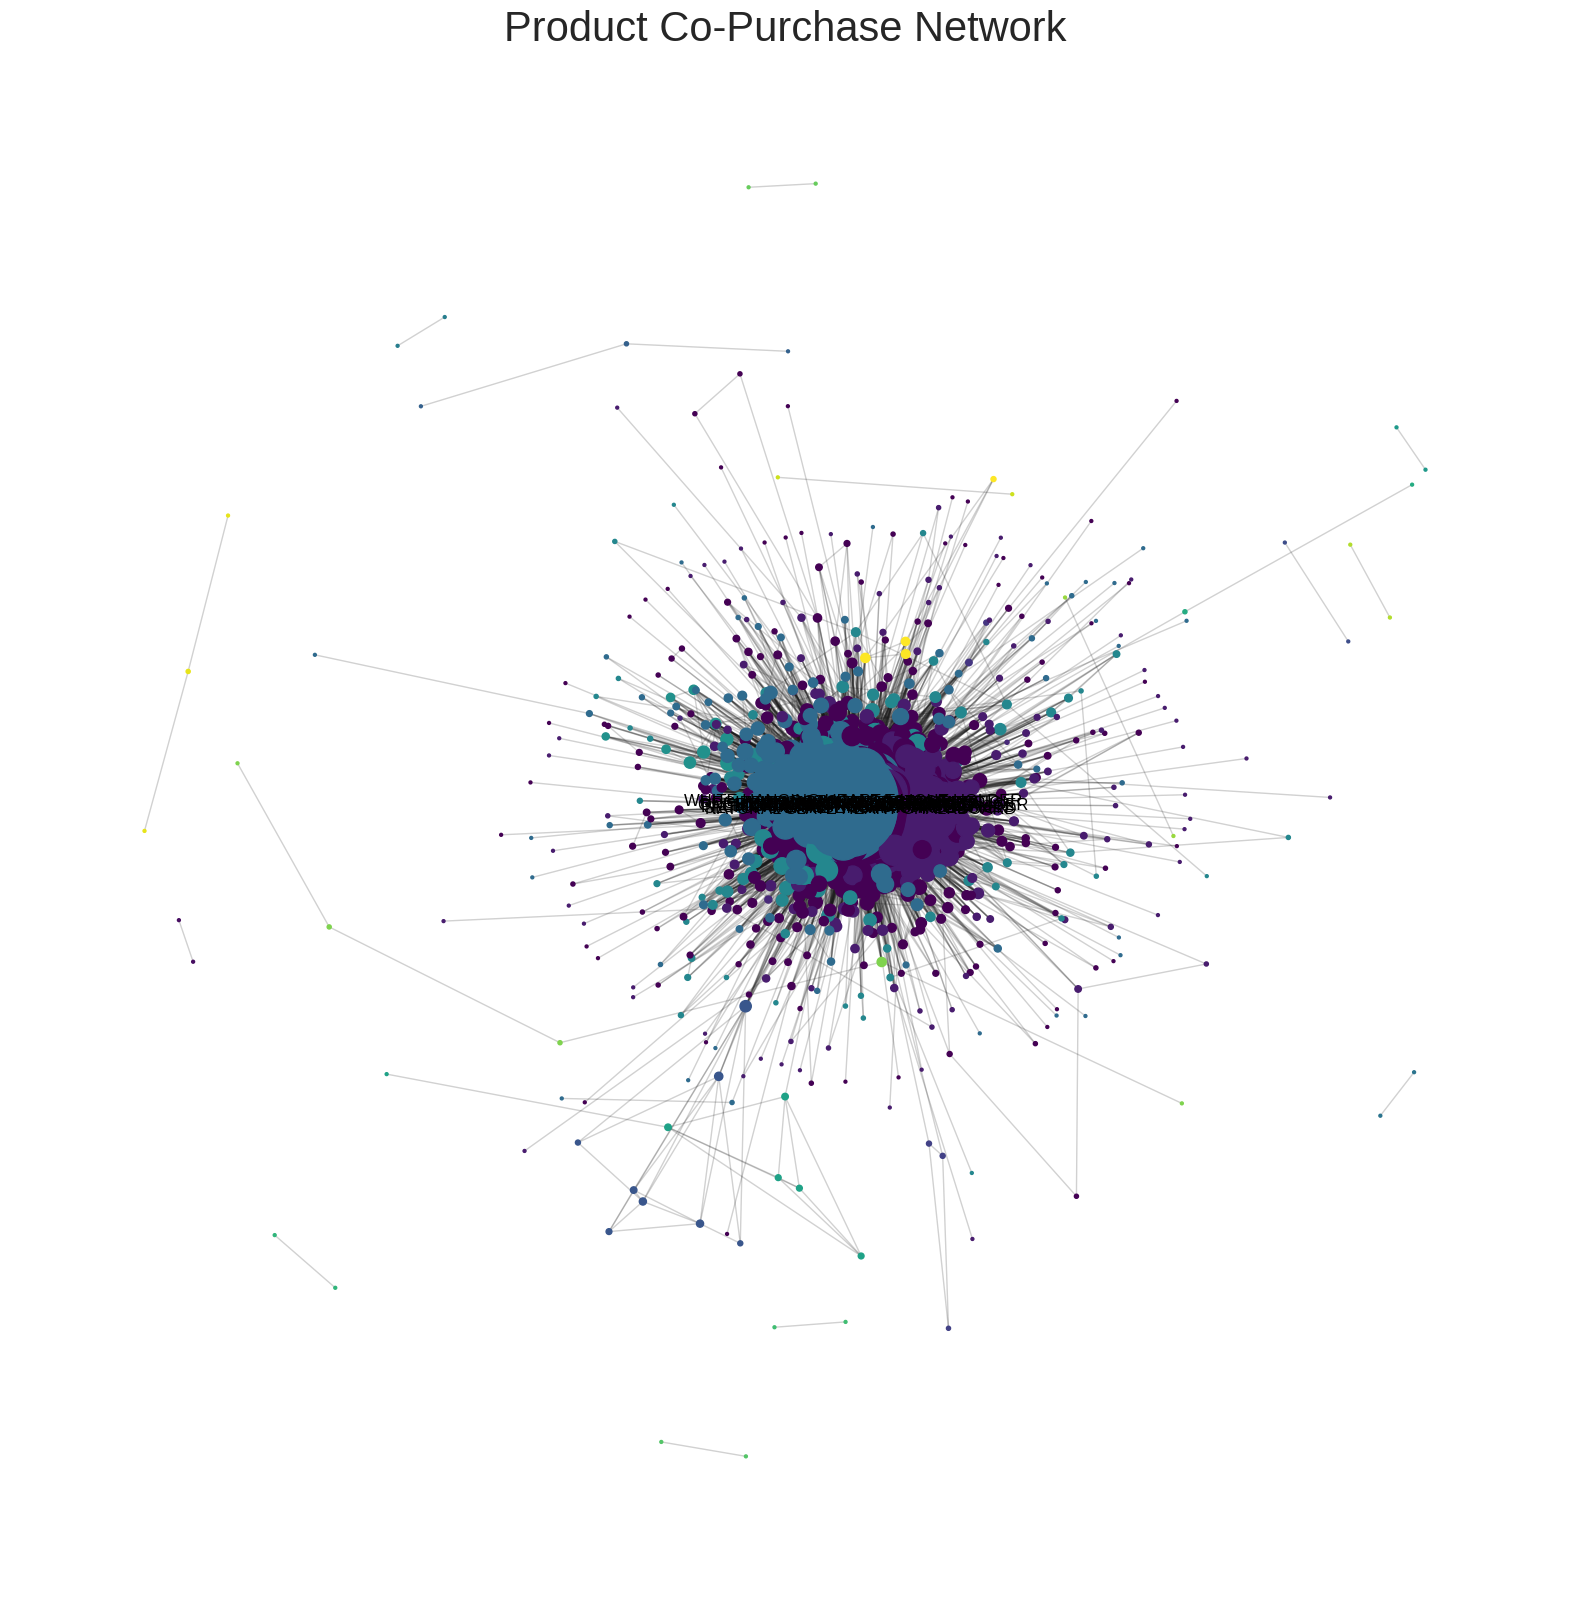

In [9]:
# Set node colors based on community
colors = [partition[node] for node in G.nodes()]
# Set node sizes based on degree centrality
sizes = [degree_centrality[node] * 10000 for node in G.nodes()]

plt.figure(figsize=(20, 20))
# Use a spring layout for better visualization
pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes, cmap=plt.cm.viridis)

# Add labels for the most important nodes for clarity
important_nodes = analysis_df.sort_values('degree_centrality', ascending=False).head(15)
labels = {row['product']: row['product'] for index, row in important_nodes.iterrows()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_color='black')

plt.title('Product Co-Purchase Network', fontsize=30)
plt.axis('off')
plt.show()

## CONCLUSION AND STRATEGIC IMPLICATIONS

This project successfully transformed a raw transaction log into a rich, interactive network graph, uncovering deep insights into customer purchasing behavior.

Key Achievements:
  1.  **Network Construction:** We successfully modeled the entire product catalog as a network, where relationships are defined by real customer behavior.
  2.  **Identification of Influential Products:** Using centrality analysis, we quantitatively identified the most important 'hub' and 'bridge' products in the catalog—items that are critical to overall sales.
  3. **Automated Ecosystem Discovery:** The Louvain community detection algorithm automatically discovered natural clusters of products, revealing hidden 'product ecosystems' that represent distinct customer need states.
  4.  **Direct Business Application:** The insights from this analysis are immediately actionable. A business can use this network to optimize store layouts, create data-driven product bundles, improve website navigation, and power a sophisticated recommendation engine. This is a direct path from advanced data analysis to tangible business value.

This project demonstrates how network analysis can provide a powerful, non-obvious, and highly strategic view of a business's product landscape.